<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR3hgLo9t64UvdrhJTpbUeWicDmEbZHWbusAw&usqp=CAU" class="center">

 

<center><h1> PROJECT OF <br> ARTIFICIAL INTELLIGENCE CM 0472-2 <br> AND <br> IMAGE AND VIDEO UNDERSTANDING CM 0524</h1></center>



<div>Student: Giosuè Zannini matr. 873810</div>
<div>Academic year 2021/2022</div>
<div><a href="https://www.kaggle.com/competitions/airbus-ship-detection/overview" target="_blank">Link to project description</a></div>

## Index

* 1 Download DataSet
* 2 Summary of DataSet
    * 2.1 Functions
    * 2.2 Main Code
* 3 YOLOv3 Model
* 4 YOLOv3 DataSet
* 5 YOLOv3 Loss
* 6 Application of K-means to find anchors for this DataSet
    * 6.1 Functions
    * 6.2 Main Code
* 7 YOLOv3 Config
* 8 DataSet augmentation for training
    * 8.1 Functions
    * 8.2 Example of all transformations apply on images
    * 8.3 Main Code
* 9 Train Model
    * 9.1 Functions
    * 9.2 Main Code
* 10 Load Model
    * 10.1 Load from my OS
    * 10.2 Load from Drive OS
* 11 Tuning Model
    * 11.1 Functions
    * 11.2 Main Code
* 12 Test Model 
    * 12.1 Functions
    * 12.2 Main Code
* 13 Demo
    * 13.1 Functions
    * 13.2 Main Code

<a id="1"/></a>
## 1 Download DataSet

In [1]:
#install kaggle library
!pip install -U -q kaggle
# create directory
!mkdir -p ~/.kaggle
# write credential inside this file NB: insert your credentials
!echo '{"username":"username","key":"key"}' > ~/.kaggle/kaggle.json
# remove permission of this file
!chmod 600 ~/.kaggle/kaggle.json
# download competition
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [06:21<00:00, 97.8MB/s]
100% 28.6G/28.6G [06:21<00:00, 80.4MB/s]


In [2]:
# create folder for dataset
!mkdir dataset
# extract train set (X, Y)
!unzip airbus-ship-detection.zip 'train_v2/*' -d ./dataset
!unzip airbus-ship-detection.zip 'train_ship_segmentations_v2.csv' -d ./dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./dataset/train_v2/f9782bdfe.jpg  
  inflating: ./dataset/train_v2/f9785ca49.jpg  
  inflating: ./dataset/train_v2/f9785e462.jpg  
  inflating: ./dataset/train_v2/f97a719d5.jpg  
  inflating: ./dataset/train_v2/f97afa376.jpg  
  inflating: ./dataset/train_v2/f97b85e3e.jpg  
  inflating: ./dataset/train_v2/f97bd0b11.jpg  
  inflating: ./dataset/train_v2/f97bd6b80.jpg  
  inflating: ./dataset/train_v2/f97bfb1b2.jpg  
  inflating: ./dataset/train_v2/f97c8cbbe.jpg  
  inflating: ./dataset/train_v2/f97cdd397.jpg  
  inflating: ./dataset/train_v2/f97d92e1e.jpg  
  inflating: ./dataset/train_v2/f97da9e70.jpg  
  inflating: ./dataset/train_v2/f97e843d3.jpg  
  inflating: ./dataset/train_v2/f97e961f2.jpg  
  inflating: ./dataset/train_v2/f97e96c68.jpg  
  inflating: ./dataset/train_v2/f97f63ae1.jpg  
  inflating: ./dataset/train_v2/f97f80839.jpg  
  inflating: ./dataset/train_v2/f97f83438.jpg  
  inflating: ./dataset/train_v2/f97fa

In [1]:
import os
# to open image
import PIL
# to plot
import matplotlib.pyplot as plt
# to create bboxes
import matplotlib.patches as patches
# to plot
import seaborn as sb
# to matrix
import numpy as np
# to read csv
import pandas as pd
from sklearn.model_selection import train_test_split
# to create table
from tabulate import tabulate
# to create model
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
# to apply transformations on images
from torchvision import transforms
# to apply transformations on images for data augmentation
import albumentations as A
import random
# to view the load bar
from tqdm import tqdm
# to transform in tensor
from albumentations.pytorch import ToTensorV2
# to create a zip file
from zipfile import ZipFile
# to download file from colab
from google.colab import files
# to move file
import shutil
# to evaluate model by mean average precision
!pip install torchmetrics
# metric for obj detection evaluation
from torchmetrics.detection.mean_ap import MeanAveragePrecision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<a id="2"/></a>
## 2 Summary of DataSet

<a id="2.1"/></a>
### 2.1 Functions

In [2]:
# create a mask to plot the position of boats
def rle_decode(mask_rle_list, shape=(768, 768)):
  # flatten matrix with zeros
  img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
  if type(mask_rle_list[0]) == float:
    return img.reshape(shape).T
  # read each boat position, mask_rle_list contains all boats in the image and mask_rle contain a single boat
  for mask_rle in mask_rle_list:
    s = mask_rle.split()
    # divide start point and lengths point for each row of matrix
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    # create end points
    ends = starts + lengths
    # write into matrix
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
  # needed to align to RLE direction (from top left corner it read column by column)
  return img.reshape(shape).T



# create bounding box for each boat
def rle_bounding_box(mask_rle_list, shape=(768, 768)):
  X, Y, X_w, Y_w = [], [], [], []
  if type(mask_rle_list[0]) == float:
    return X, Y, X_w, Y_w
  # read each boat position, mask_rle_list contains all boats in the image and mask_rle contain a single boat
  for mask_rle in mask_rle_list:
    # split string
    s = mask_rle.split()
    # divide start point and lengths point for each row of matrix and convert to int
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    # because the upper corner starts with 0
    starts -= 1
    # create end points
    ends = starts + lengths
    # left x
    x_t = min(starts) // shape[0]
    # right x
    x_b = max(starts) // shape[0]
    # append 
    X.append(x_t)
    X_w.append(x_b - x_t)
    # list to contain the value in y for starts and ends lists
    y_s, y_e = [], []
    # compute value for y
    for s, e in zip(starts, ends):
      # top y
      y_s.append(s % shape[0])
      # bottom y
      y_e.append(e % shape[0])
    # append
    Y.append(min(y_s))
    # sometimes this value can be 0, zero means the last pixel in the bottom, so I override with shape of image
    max_y = max(y_e)
    if max_y == 0:
      max_y = shape[0]
    Y_w.append(max_y - min(y_s))
  return X, Y, X_w, Y_w

<a id="2.2"/></a>
### 2.2 Main Code

In [ ]:
# read file with pairs (name img, encoded pixels)
df = pd.read_csv("/content/dataset/train_ship_segmentations_v2.csv")
# print summary 
data = [["Size", len(list(set(df["ImageId"]))), len(list(set(df.dropna(subset=["EncodedPixels"])["ImageId"]))), 
         len(list(set(df["ImageId"]))) - len(list(set(df.dropna(subset=["EncodedPixels"])["ImageId"])))]]
col_names = ["", "All examples", "Positive examples", "Negative examples"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒══════╤════════════════╤═════════════════════╤═════════════════════╕
│      │   All examples │   Positive examples │   Negative examples │
╞══════╪════════════════╪═════════════════════╪═════════════════════╡
│ Size │         192556 │               42556 │              150000 │
╘══════╧════════════════╧═════════════════════╧═════════════════════╛


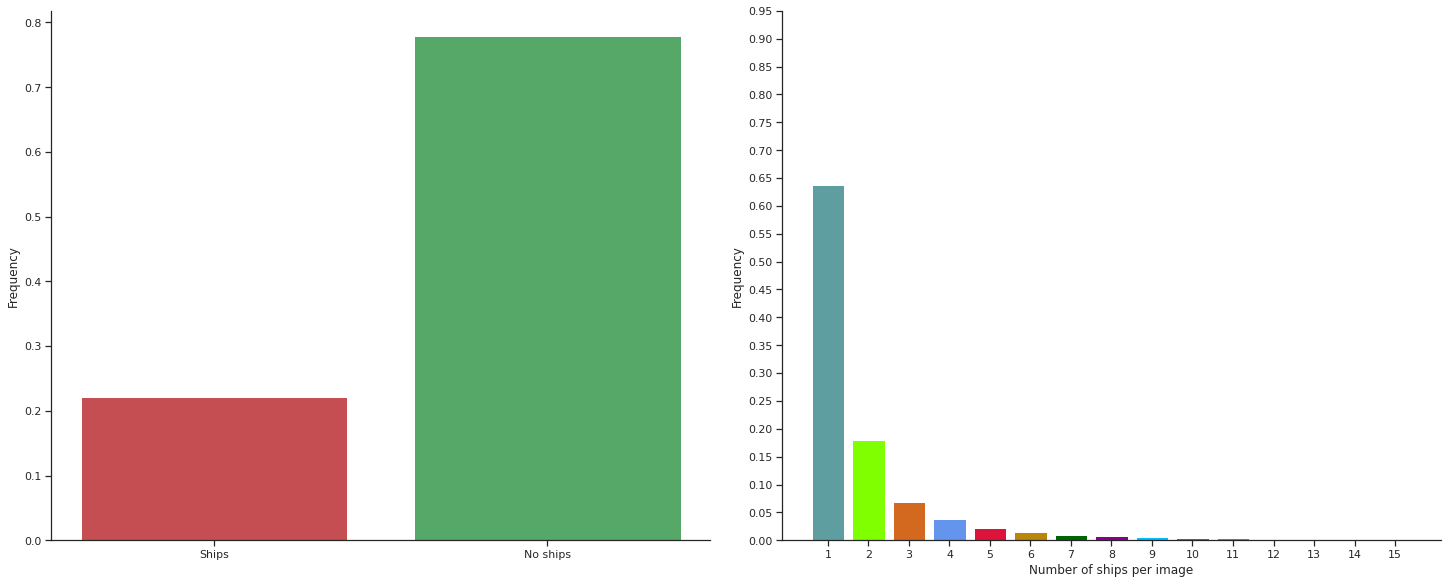

In [ ]:
# custom parameters for theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="ticks", rc=custom_params)
# create figure
fig, axs = plt.subplots(1, 2, figsize=(20, 8), constrained_layout=True)
# find the frequency of ship and no ship
y = [float(len(list(set(df.dropna(subset=["EncodedPixels"])["ImageId"])))) / float(len(list(set(df["ImageId"])))), 
     float(len(list(set(df["ImageId"]))) - len(list(set(df.dropna(subset=["EncodedPixels"])["ImageId"])))) / float(len(list(set(df["ImageId"]))))]
# bar plot for ships
axs[0].bar(["Ships", "No ships"], y, align='center', color=["r", "g"])
# set labels of axes
axs[0].set_ylabel("Frequency")
# eliminate the row that have not a ship
df1 = df.dropna(subset=["EncodedPixels"])
# determine for each image the number of ship inside
df2 = df1.pivot_table(columns=["ImageId"], aggfunc='size')
l_df2 = list(df2)
s_df2 = set(l_df2)
# determine the frequency
y_2 = [float(l_df2.count(val)) / float(len(list(set(df.dropna(subset=["EncodedPixels"])["ImageId"])))) for val in s_df2]
# bar plot
axs[1].bar(list(s_df2), y_2, align='center', color=['cadetblue', 'chartreuse', 'chocolate', 'cornflowerblue', 'crimson', 
                                                    'darkgoldenrod', 'darkgreen', 'darkmagenta', 'deepskyblue', 'fuchsia', 
                                                    'grey', 'lawngreen', 'lightcoral', 'lime', 'mediumpurple'])
# set labels of axes
axs[1].set_ylabel("Frequency")
axs[1].set_yticks(np.arange(0, 1, step=0.05))
axs[1].set_xticks(range(1, len(list(s_df2)) + 1))
axs[1].set_xlabel("Number of ships per image")
pass # with this colab doesn't print the last line of this code

In [ ]:
# list of all images that have al least one ship
images = list(set(df.dropna(subset=["EncodedPixels"])["ImageId"]))
# save 50 random images
save_img_names = [np.random.choice(images) for i in range(50)]

In [ ]:
# create axes for 10 images where each of them has 3 filters
fig, axs = plt.subplots(10, 3, figsize=(30, 100), constrained_layout=True)
for row, ax_row in enumerate(axs):
  # take img
  select_img = save_img_names[row]
  # take image
  img = np.array(PIL.Image.open(f"/content/dataset/train_v2/{select_img}"))

  # original image---
  # print image
  ax_row[0].imshow(img)
  # set title
  ax_row[0].set_title("Original")
  # remove y ticks
  ax_row[0].set_yticks([])
  # remove x ticks
  ax_row[0].set_xticks([])
  # set y label
  ax_row[0].set_ylabel(select_img)
  # set color of y label
  ax_row[0].yaxis.label.set_color('blue')

  # filter image---
  # remove axis
  ax_row[1].axis('off')
  # list that contains a set of list where each of them has all coordinates to visualize a boat in a specific image
  list_of_coordinates = list(df[df["ImageId"] == select_img]["EncodedPixels"])
  # create a mask to visualize
  mask_for_plot = rle_decode(list_of_coordinates)
  # plot mask
  ax_row[1].imshow(mask_for_plot, alpha=0.4)
  ax_row[1].set_title("RLE")

  # bounding box image---
  # remove axis
  ax_row[2].axis('off')
  # create a bounding box for each boat
  X, Y, X_w, Y_w = rle_bounding_box(list_of_coordinates)
  # plot image
  ax_row[2].imshow(img)
  # set title
  ax_row[2].set_title("Bounding Box")
  # extract each bounding box for this image
  for x, y, x_w, y_w in zip(X, Y, X_w, Y_w):
    # Create a Rectangle patch
    rect = patches.Rectangle((x, y), x_w, y_w, linewidth=2, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax_row[2].add_patch(rect) 


Output hidden; open in https://colab.research.google.com to view.

<a id="3"/></a>
## 3 YOLOv3 Model

In [3]:
""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""

# Tuple : (out_channels, kernel_size, stride)
# List : ["B", n_repeats] are residual blocks, number of times that the network repeat these layers
# NB: in YOLOv3 all conv use the same padding
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S", # first scale prediciton
    (256, 1, 1),
    "U", # upsampling
    (256, 1, 1),
    (512, 3, 1),
    "S", # second scale prediction
    (128, 1, 1),
    "U", # umsampling
    (128, 1, 1),
    (256, 3, 1),
    "S", # last scale prediction
]


class CNNBlock(nn.Module):                      # batch norm activation function
  def __init__(self, in_channels, out_channels, bn_act = True,  **kwargs):
                                                                      # kernel size and stride
    super(CNNBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, bias = not bn_act, **kwargs)
    self.bn = nn.BatchNorm2d(out_channels)
    self.leaky = nn.LeakyReLU(0.1)
    self.use_bn_act = bn_act
  
  def forward(self, x):
    if self.use_bn_act:
      return self.leaky(self.bn(self.conv(x)))
    else:
      return self.conv(x)



class ResidualBlock(nn.Module):
  def __init__(self, channels, use_residual=True, num_repeats=1):
    super(ResidualBlock, self).__init__()
    self.layers = nn.ModuleList()
    for _ in range(num_repeats):
      self.layers += [nn.Sequential(
                    CNNBlock(channels, channels//2,  kernel_size=1),
                    CNNBlock(channels//2, channels,  kernel_size=3, padding=1)
      )]
    
    self.use_residual = use_residual
    self.num_repeats = num_repeats

  def forward(self, x):
    for layer in self.layers:
      x = layer(x) + x if self.use_residual else layer(x)
    return x



class ScalePrediction(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(ScalePrediction, self).__init__()
    self.pred = nn.Sequential(
        CNNBlock(in_channels, 2*in_channels, kernel_size=3, padding=1),
        #                         number of anchors
        CNNBlock(2*in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1)
    )
    self.num_classes = num_classes

  def forward(self, x):
    return (
        self.pred(x)
        #        n batch, anchor box, bb p0 and prob
        .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
        # change order of elements
        .permute(0, 1, 3, 4, 2)
    )#N x 3 x 13 x 13 x 5 + num_classes



class YOLOv3(nn.Module):
  def __init__(self, in_channels=3, num_classes=1):
    super(YOLOv3, self).__init__()
    self.num_classes = num_classes
    self.in_channels = in_channels
    self.layers = self._create_conv_layers()

  def forward(self, x):
    # keep output for each scale prediction
    outputs = []
    # keep root connections
    route_connections = []
    for layer in self.layers:      

      # this is a branch so the x value isn't changed because it will use in the next conv layer
      if isinstance(layer, ScalePrediction):
        outputs.append(layer(x))
        # I need this because this is a parallel branch, so the x must be the input of next layer
        continue

      # x for next layer of conv
      x = layer(x)

      # is the case of concatenation
      if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
        route_connections.append(x)

      elif isinstance(layer, nn.Upsample):
        # concatenate the last route connection and remove it from list
        x = torch.cat([x, route_connections.pop()], dim=1)
    return outputs


  def _create_conv_layers(self):
    layers = nn.ModuleList()
    in_channels = self.in_channels

    for module in config:
      # means CNN block
      if isinstance(module, tuple):
        out_channels, kernel_size, stride = module
        layers.append(
            CNNBlock(
              in_channels, 
              out_channels, 
              kernel_size=kernel_size,
              stride=stride,
              padding=1 if kernel_size==3 else 0
            )
        )
        # the output of this block is the input of next block
        in_channels = out_channels

      elif isinstance(module, list):
        num_repeats = module[1]
        layers.append(ResidualBlock(in_channels, num_repeats=num_repeats))

      elif isinstance(module, str):
        # means scale prediction
        if module == "S":
          layers += [
              ResidualBlock(in_channels, use_residual=False, num_repeats=1),
              CNNBlock(in_channels, in_channels//2, kernel_size=1),
              ScalePrediction(in_channels//2, num_classes=self.num_classes)
          ]
          in_channels = in_channels // 2
        # means upsampling
        elif module == "U":
          layers.append(nn.Upsample(scale_factor=2))
          # because there are a concatenation from previous layer (watch image of architecture)
          in_channels = in_channels * 3
    return layers

<a id="4"/></a>
## 4 YOLOv3 DataSet

In [4]:
# intersection over union about width and height
def iou(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
        boxes1[..., 1], boxes2[..., 1]
    )
    union = (
        boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
    )
    return intersection / union

In [5]:
"""TOGLIERE L'ULTIMO VALORE CHE INDICA LA CLASSE"""

# dataset for training
class YOLODataset(Dataset):
  def __init__(
          self, 
          pandas_file,
          img_dir,
          anchors, #  bbox for each scale, so we have 9 bbox
          S, # is a grid size
          C=1, 
          transformations = None
  ):
    self.annotations = pandas_file
    self.img_dir = img_dir
    self.S = S #               |3 anchors for first scale|3 anchors for second scale|....
    self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
    # total number of anchors (bbox)
    self.num_anchors = self.anchors.shape[0]
    # we assume that we have a specific set of scales, in this case is 3 (3 box for cell), but I can change the number of anchors that I have
    self.num_anchors_per_scale = self.num_anchors // 3
    # number of classes
    self.C = C
    # case when we have more boxes with high iou in a cell, we take the max but the other prediction if have an iou > 0.5 we must ignore
    self.ignore_iou_thresh = 0.5
    self.transformations = transformations

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    # [x, y, w, h, label], if image has more ships this is a list of list
    bboxes = self.annotations.iloc[index, 1]
    img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
    # load image and covert in RGB so if I have a gray image I still use YOLO v3 and convert to tensor
    image = torch.from_numpy(np.array(PIL.Image.open(img_path).convert("RGB")))
    # rgb, dim, dim
    image = image.permute(2, 0, 1)
    # cast all to float
    image = image.float()
    # apply transformations
    if self.transformations:
      image = self.transformations(image)
    
      # at the end target is a list with 3 tensors
    # I assume that have 3 scale predictions and assuming that I have the same number of anchors at each scale
    targets = [torch.zeros((self.num_anchors_per_scale, S, S, 6)) for S in self.S] # [p_0, x, y, w, h, c]
    #                        num bbox for each cell, S, S, (p0, x, y, w, h, c)
    # for each box in boxes, so the number of ships in this image
    for box in bboxes:
      # I want to assign which anchors should be responsible and which cell should be responsible for each S
      # for all the three different scales
      # I compare the box with 9 anchors
      # this calculate the iou for w and h among all anchors and box
      iou_anchors = iou(torch.tensor(box[2:4]), self.anchors)
      # find the best, dim=0 indicates the first dimension of tensor (here this tensor has only one dim)
      # return a list with indices form the best to the worst
      anchor_indices = iou_anchors.argsort(descending=True, dim=0)
      x, y, width, height, class_label = box
      # I want that for each scale there is an anchor
      has_anchor = [False, False, False]
      # EVERYTHING IN YOLO IS RELATED TO THE CELL
      for anchor_idx in anchor_indices:
        # I find what scale is for this anchor
        scale_idx = anchor_idx // self.num_anchors_per_scale
        # I find what anchor is for this (scale_idx is the scale for this anchor but I don't know what specific bbox is) specific scale
        anchor_on_scale = anchor_idx % self.num_anchors_per_scale
        # grid size (es 13x13, 26x26, 52x52)
        S = self.S[scale_idx]
        # the box in train file is related with the entire image, so I must change coordinate relate to cell
        # so i and j identify a specific cell for this scale
        i, j = int(S * y), int(S * x) # x=0.5, S=13 --> int(6.5) = cell number 6
        anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]   # at the beginnnig this value is 0

        # I check if this anchor is taken by some other obj and I don't have an anchor in this particular scale
        # NB I want to have a prediction for each scale
        if not anchor_taken and not has_anchor[scale_idx]:
          # means this is a good bbox because there is high probability that there is an obj
          targets[scale_idx][anchor_on_scale, i, j, 0] = 1
          # x and y value in the cell
          x_cell, y_cell = S * x - j, S * y - i # 6.5 - 6 = 0.5 move the anchor to center the box
          width_cell, height_cell = width * S, height * S
          box_coordinates = torch.tensor(
              [x_cell, y_cell, width_cell, height_cell]
          )
          targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates
          targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)
          has_anchor[scale_idx] = True
        # I want only one anchor for each cell so in this way I ignore bbox with an higher value of iou
        elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
          targets[scale_idx][anchor_on_scale, i, j, 0] = -1 # ignore this prediction
    return image, tuple(targets)



# dataset for evaluation
class YOLODatasetForEvaluation(Dataset):
  def __init__(
          self, 
          pandas_file, 
          img_dir,
          C=1, 
          transformations = None
  ):
    self.annotations = pandas_file
    self.img_dir = img_dir
    # number of classes
    self.C = C
    self.transformations = transformations

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, index):
    # [x, y, w, h, label], if image has more ships this is a list of list
    bboxes = self.annotations.iloc[index, 1]
    img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
    # load image and covert in RGB so if I have a gray image I still use YOLO v3 and convert to tensor
    image = torch.from_numpy(np.array(PIL.Image.open(img_path).convert("RGB")))
    # rgb, dim, dim
    image = image.permute(2, 0, 1)
    # cast all to float
    image = image.float()
    # apply transformations
    if self.transformations:
      image = self.transformations(image)
    return image, bboxes



# customise how to return batch, this is a function
def collate_for_evaluation(batch):
  img = torch.tensor([item[0].numpy() for item in batch])
  target = [torch.tensor(item[1]) for item in batch]
  return img, target

<a id="5"/></a>
## 5 YOLOv3 Loss

In [6]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        # find left upper corner
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        # find rigth bottom corner
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        # find left upper corner
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        # find rigth bottom corner
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [7]:
# loss function for model
class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # for box prediciton
        self.mse = nn.MSELoss()
        # sigmoid applied on binary cross entropy
        self.bce = nn.BCEWithLogitsLoss()
        # sigmoid
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

        # variables to know the loss of each single loss, in this way I can print them 
        self.no_obj_loss = 0.
        self.obj_loss = 0.
        self.b_loss = 0.

    # I must compute the loss for each of the three different scales
    def forward(self, predictions, target, anchors):
        # Check where obj and noobj (we ignore if target == -1)
        obj = target[..., 0] == 1  # in paper this is Iobj_i
        noobj = target[..., 0] == 0  # in paper this is Inoobj_i

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.bce(
            (predictions[..., 0:1][noobj]), (target[..., 0:1][noobj]),
        )
        self.no_obj_loss = no_object_loss

        # case when the image has ships
        if obj.sum() != 0:

          # ==================== #
          #   FOR OBJECT LOSS    #
          # ==================== #

          anchors = anchors.reshape(1, 3, 1, 1, 2)
          box_preds = torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
          ious = intersection_over_union(box_preds[obj], target[..., 1:5][obj]).detach()
          object_loss = self.mse(self.sigmoid(predictions[..., 0:1][obj]), ious * target[..., 0:1][obj])
          self.obj_loss = object_loss
          
          # ======================== #
          #   FOR BOX COORDINATES    #
          # ======================== #

          predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])  # x,y coordinates
          target[..., 3:5] = torch.log(
              (1e-16 + target[..., 3:5] / anchors)
          )  # width, height coordinates
          box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])
          self.b_loss = box_loss

        # case when there isn't any ships in image
        else:
          object_loss = torch.tensor(0.)
          self.obj_loss = object_loss
          
          box_loss = torch.tensor(0.)
          self.b_loss = box_loss
          
        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
        )

<a id="6"/></a>
## 6 Application of K-means to find anchors for this DataSet

<a id="6.1"/></a>
### 6.1 Functions

In [8]:
# create dataset with bbox where x, and y are the center of image and all coordinate are rescaled from 0 to 1 and for image where there is more ships I merge them into a single image 
def normalize_dataset_For_obj_detection(path_file, image_size = 768., only_ships=False):
  # read file with pairs (name img, encoded pixels)
  df = pd.read_csv(path_file)
  # remove the empty images
  if only_ships:
    df=df.dropna().reset_index(drop=True)
    # change name of columns
  df.columns = ["ImageId", "Box_Label"]
  # transform each coordinate in bbox
  for en, img_name in enumerate(df["ImageId"]):
    X, Y, X_w, Y_w = rle_bounding_box([df["Box_Label"].iloc[en]])
    # this is the case where there is a ship
    if X:
      # move the x and y from the corner to the center of bbox NB the 0.001 means to avoid error in transformation images
      X = [(X[0] + X_w[0] / 2.) + 0.006]
      Y = [(Y[0] + Y_w[0] / 2.) + 0.006]
      # rescale between [0, 1] and create a unique list
      df.at[en , "Box_Label"] = [(X[0] / image_size), (Y[0] / image_size), (X_w[0] / image_size), (Y_w[0] / image_size), 1]
    # this is the case where there isn't a ship
    else:
      df.at[en , "Box_Label"] = []
  # group all instance with same image where the Box_Label concat with other of same image
  df = df.groupby(['ImageId'], as_index=False).agg({'Box_Label': lambda x: + x})
  # normalize all elements in second column
  for i in range(len(df["ImageId"])):
    # case when there is more ships in image
    if isinstance(df.iloc[i, 1], np.ndarray):
      df.at[i, "Box_Label"] = list(df.iloc[i, 1])
    # case when there is only one ship in image, the first part is for the case the list is empty so I don't go in segmentation fault
    elif df.iloc[i, 1] and isinstance(df.iloc[i, 1][0], float) :
      df.at[i, "Box_Label"] = [df.iloc[i, 1]]
  return df


# create dataset with bbox where x, and y are the left upper corner of image and for image where there is more ships I merge them into a single image 
# I can use this dataset to plot images and their bboxes, so each bbox has [top left corner x y, w, h]
def dataset_bbox_for_obj_detection(path_file, only_ships=False):
  # read file with pairs (name img, encoded pixels)
  df = pd.read_csv(path_file)
  # remove the empty images
  if only_ships:
    df=df.dropna().reset_index(drop=True)
  df.columns = ["ImageId", "Box_Label"]
  for en, img_name in enumerate(df["ImageId"]):
    X, Y, X_w, Y_w = rle_bounding_box([df["Box_Label"].iloc[en]])
    if X:
      # create a unique list
      df.at[en , "Box_Label"] = [(X[0]), (Y[0]), (X_w[0]), (Y_w[0])] 
      # for batch normalization
    else:
      df.at[en , "Box_Label"] = []
  # group all instance with same image 
  df = df.groupby(['ImageId'], as_index=False).agg({'Box_Label': lambda x: + x})
  # normalize all elements in second column
  for i in range(len(df["ImageId"])):
    if isinstance(df.iloc[i, 1], np.ndarray):
      df.at[i, "Box_Label"] = list(df.iloc[i, 1])
    elif df.iloc[i, 1] and isinstance(df.iloc[i, 1][0], np.int64) :
      df.at[i, "Box_Label"] = [df.iloc[i, 1]]
  return df

In [9]:
# color map for plot
def color_map(val):
  if val == 0:
    return 'tab:blue'
  elif val == 1:
    return 'tab:orange'
  elif val == 2:
    return 'tab:green'
  elif val == 3:
    return 'tab:red'
  elif val == 4:
    return 'tab:purple'
  elif val == 5:
    return 'tab:brown'
  elif val == 6:
    return 'tab:pink'
  elif val == 7:
    return 'tab:gray'
  else:
    return 'tab:olive'


# determine intersection over union between height and weight
def iou_cluster(p_a, p_b):
  intersection = min(p_a[0], p_b[0]) * min(p_a[1], p_b[1])
  area_p_a = p_a[0] * p_a[1]
  area_p_b = p_b[0] * p_b[1]
  union = area_p_a + area_p_b - intersection
  return intersection / union


# determine cluster with metric iou (assume that X is a list of pair)
def k_means_iou_metric(X, n_cluster, max_iter=300, convergence_threshold = 1e-10):
  min_w, max_w = min(X[..., 0]), max(X[..., 0])
  min_h, max_h = min(X[..., 1]), max(X[..., 1])
  # actual value of obj function that I want to minimize
  actual_value_of_object_function = 0.
  # create random centroids with 2 coordinates
  centroid = [(np.random.rand() * (max_w - min_w) + min_w, np.random.rand() * (max_h - min_h) + min_h) for i in range(n_cluster)]
  # array that reflect the class of each data point
  belong_cluster = np.full((X.shape[0]), -1)
  n_cicles = 0
  while True:
    """ Assign data point to closest cluster center """
    # watch all points
    for pos_point, data_point in enumerate(X):
      # distance between data and first cluster, and label of cluster
      min_ = [1. - iou_cluster(data_point, centroid[0]), 0]
      for c in range(1, n_cluster):
        # distance between data and other clusters, and label of cluster
        tmp_min = [1. - iou_cluster(data_point, centroid[c]), c]
        # change minimum
        if tmp_min[0] < min_[0]:
          min_ = tmp_min
      # assign point to nearest class
      belong_cluster[pos_point] = min_[1]

    """ Change the cluster center to the average of its points """
    # dictionary that has as index the cluster index and inside there is [sum coordinates, number of elements that belong to cluster]
    notes_for_new_centers = {i:[(0, 0), 0] for i in range(n_cluster)}
    for pos_point, cluster_class in enumerate(belong_cluster):
      notes_for_new_centers[cluster_class][0] = tuple(map(lambda i, j: i + j, notes_for_new_centers[cluster_class][0], X[pos_point]))
      notes_for_new_centers[cluster_class][1] += 1
    # change centroid of each cluster
    for c in notes_for_new_centers.keys():
      centroid[c] = tuple(map(lambda i: i / notes_for_new_centers[c][1], notes_for_new_centers[c][0]))

    """ Object function """
    tmp_value_of_object_function = 0.
    for pos_point, cluster_class in enumerate(belong_cluster):
      tmp_value_of_object_function += pow(1. - iou_cluster(X[pos_point], centroid[cluster_class]), 2)

    if n_cicles != 0 and abs(actual_value_of_object_function - tmp_value_of_object_function) <= convergence_threshold:
      break
    
    elif n_cicles >= max_iter:
      print("REACH MAX ITERATION")
      break

    actual_value_of_object_function = tmp_value_of_object_function
    n_cicles += 1
    
  return actual_value_of_object_function, centroid, belong_cluster

<a id="6.2"/></a>
### 6.2 Main Code

In [ ]:
# return dataset with only ships in box coordinate
DataSet_K = dataset_bbox_for_obj_detection("/content/dataset/train_ship_segmentations_v2.csv", only_ships=True)
# create pair in right way for k-means algorithm
coordinate = []
for l in DataSet_K["Box_Label"]:
  for box in l:
    # append only w, h for each boat in each image
    coordinate.append(box[2::])

# convert to numpy
coordinate = np.array(coordinate)
# apply k-means
obj_value, centroid_list, class_of_point_list = k_means_iou_metric(coordinate, 9)

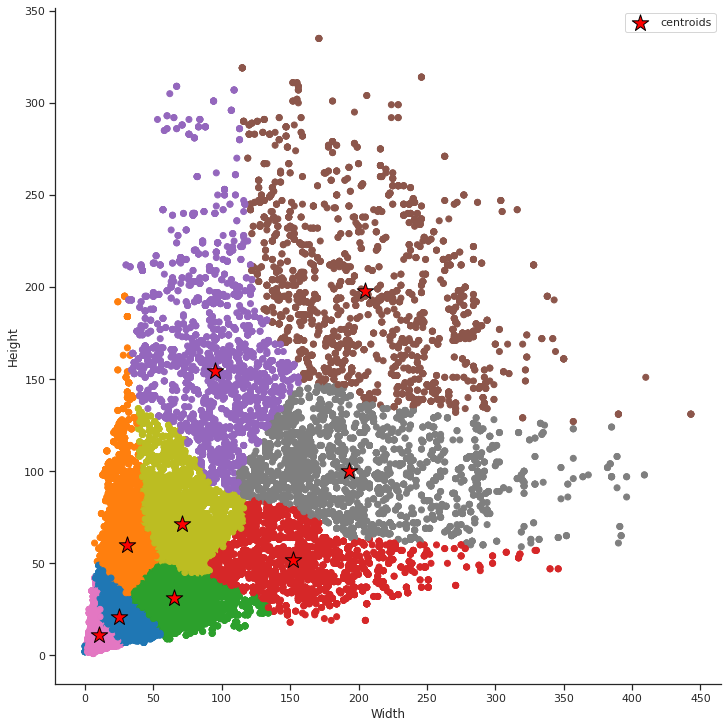

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sb.set_theme(style="ticks", rc=custom_params)
# create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 10), constrained_layout=True)
ax.scatter(coordinate[..., 0], coordinate[..., 1], c=[color_map(c) for c in class_of_point_list])
ax.scatter(np.array(centroid_list)[..., 0], np.array(centroid_list)[..., 1], marker='*',c='red', edgecolor='black', s=300, label="centroids")
ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_xticks(range(0, 451, 50))
ax.set_yticks(range(0, 351, 50))
ax.legend()
pass

In [ ]:
# sort centroid list considering the mean about h and w and transform in np
centroid_sorted = np.array(sorted(np.array(centroid_list), key=lambda x: (x[0] + x[1]) / 2.))
# rescale anchors between [0, 1]
centroid_sorted = centroid_sorted / 768
# print new anchors
print(f"Anchor for first scale:\n {centroid_sorted[6::]}")
print(f"Anchor for second scale:\n {centroid_sorted[3:6]}")
print(f"Anchor for third scale:\n {centroid_sorted[0:3]}")

Anchor for first scale:
 [[0.1234215  0.20099616]
 [0.25167385 0.13067097]
 [0.26671752 0.25736493]]
Anchor for second scale:
 [[0.08430322 0.04048997]
 [0.09197529 0.09288585]
 [0.19802365 0.0674363 ]]
Anchor for third scale:
 [[0.01375336 0.01428806]
 [0.03196314 0.02729713]
 [0.04040616 0.07824028]]


<a id="7"/></a>
## 7 YOLOv3 Config 

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if(torch.cuda.is_available()):
  print(DEVICE, torch.cuda.get_device_name(0))
else:
  print(DEVICE)

NUM_WORKERS = 4
BATCH_SIZE = 16
IMAGE_SIZE = 768
NUM_CLASSES = 0
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 200
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
IMG_DIR = "/content/dataset/train_v2"
LABEL_FILE = "/content/dataset/train_ship_segmentations_v2.csv"


# anchors related to entire image
ANCHORS = [
    [(0.12, 0.20), (0.25, 0.13), (0.27, 0.26)],  # 24
    [(0.08, 0.04), (0.09, 0.09), (0.2, 0.07)],   # 48
    [(0.01, 0.01), (0.03, 0.02), (0.04, 0.08)],  # 96
]  # Note these have been rescaled to be between [0, 1]
# anchors rescaled regard S
SCALED_ANCHORS = (torch.tensor(ANCHORS) * torch.tensor(S).unsqueeze(1).unsqueeze(2).repeat(1, 3, 2)).to(DEVICE)  

cuda Tesla T4


<a id="8"/></a>
## 8 DataSet augmentation for training

<a id="8.1"/></a>
### 8.1 Functions

In [11]:

# transformations that I apply to increase the robustness of model
image_transformations = A.Compose(
    [ 
        # modify color of image
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.5),
        # modify brightness
        A.RandomBrightnessContrast(p=0.2),
        # modify rgb colors
        A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.4),
        # rotate image with boarder
        A.IAAAffine(shear=15, p=0.4, mode="constant"),
        # horizontal flip
        A.HorizontalFlip(p=0.6),
        # vertical flip
        A.VerticalFlip(p=0.6),
        # blur image
        A.Blur(p=0.1),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
        # transform in tensor (3 x 768 x 768)
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[])
)


# increment dataset with transformed images and corresponding bbox(save new images inside the rigth folder where there are other images and create new df for training)
def increment_dataset(df, transformation):
  # class to transform tensor in img
  FromTensorToImg = transforms.ToPILImage()
  # create dataframe with modified images
  df_aumentation = pd.DataFrame(columns=['ImageId', 'Box_Label'])
  for i in tqdm(range(0, len(df["ImageId"]), 15)):
    # in this way I modified images at random (with 0.7 the image is changed)
    if random.choices([0,1], weights=(70, 30), k=1)[0]:
      continue
    # extract original image
    image_original = np.array(PIL.Image.open(os.path.join(IMG_DIR, df.iloc[i, 0])))
    # to create random images from the original image
    for repeat in range(1, random.randint(4, 9)):
      # name for new image
      name = "aug"+str(repeat)+df.iloc[i, 0]
      # transformed image and bbox
      augmented_image = transformation(image=image_original, bboxes=df.iloc[i, 1])
      # convert list of tuple in list of list
      bbox = create_list_for_df(augmented_image["bboxes"])
      # transform tensor (3 x 768 x768) in image (768 x 768 x 3) and save it inside right directory
      FromTensorToImg(augmented_image["image"]).save(os.path.join(IMG_DIR, name))
      # insert in dataset
      df_aumentation = df_aumentation.append({"ImageId" : name, "Box_Label" : bbox}, ignore_index=True)
  # concatenation of original df and transformed df
  df_aumentation = pd.concat([df, df_aumentation], ignore_index=True)
  # shuffle dataset
  return df_aumentation.sample(frac=1)


# convert list of tuple in list of list, in this way I can add this into dataset for training
def create_list_for_df(aug_bbox):
  return [list(i) for i in aug_bbox]


/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:348: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)


<a id="8.2"/></a>
### 8.2 Example of all transformations apply on images

In [ ]:
# list of all transformation that I use with probability 1 so in this way I can show the tnransformations
transformation_list = [(A.ColorJitter(brightness=1, contrast=1, saturation=1, hue=1, p=1), "ColorJitter"),
                       (A.RandomBrightnessContrast(p=1), "BrightnessContrast"),
                       (A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=1), "RGBShift"),
                       (A.Compose([A.IAAAffine(shear=15, p=1, mode="constant")], bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[])), "ShiftScaleRotate"),
                       (A.Compose([A.HorizontalFlip(p=1)], bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[])), "HorizontalFlip"),
                       (A.Compose([A.VerticalFlip(p=1)], bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[])), "VerticalFlip"),
                       (A.Blur([7, 7], p=1), "Blur"),
                       ()]


In [ ]:
# take df with only ships
df_train_SHIPS_plot = normalize_dataset_For_obj_detection(LABEL_FILE, only_ships=True)

In [ ]:
# selected image
selected_image = 89
# create plots
fig, ax = plt.subplots(3, 3, figsize=(30, 30), constrained_layout=True)
# original image------
# set title
ax[0, 0].set_title("Original")
# remove y ticks
ax[0, 0].set_yticks([])
# remove x ticks
ax[0, 0].set_xticks([])
# set color of y label
ax[0, 0].yaxis.label.set_color('blue')
# original image
image_original = np.array(PIL.Image.open(os.path.join(IMG_DIR, df_train_SHIPS_plot.iloc[selected_image, 0])))
# original bboxes
original_bboxes = df_train_SHIPS_plot.iloc[selected_image, 1]
# print image
ax[0, 0].imshow(image_original)
# extract each bounding box for this image
for or_bbox in original_bboxes:
  # Create a Rectangle patch
  rect = patches.Rectangle(((or_bbox[0] - or_bbox[2] / 2.) * IMAGE_SIZE, (or_bbox[1] - or_bbox[3] / 2.) * IMAGE_SIZE), or_bbox[2] * IMAGE_SIZE, or_bbox[3]* IMAGE_SIZE,
                           linewidth=2, edgecolor='r', facecolor='none')
  # Add the patch to the Axes
  ax[0, 0].add_patch(rect) 
# transformed image-----
#  transfomration images NB with 1 means that enumerate start from 1 to count
for i, trans in enumerate(transformation_list, 1):
  # case when a transfomration is empty (I use this technique because I have 7 transfomration and I want to show 3 images per row)
  if not trans:
    ax[i // 3, i % 3].axis('off')
    continue

  # apply transformation on image 
  augmentations = trans[0](image=image_original, bboxes=df_train_SHIPS_plot.iloc[selected_image, 1])
  # modified image
  image_trans = augmentations["image"]
  # modified bboxes
  bboxes_trans = augmentations["bboxes"]
  # no axis
  ax[i // 3, i % 3].axis('off')
  # permute and plot image, I must permute because the dimension is 3 x 768 x 768 and for plotting I need 768 x 768 x 3
  ax[i // 3, i % 3].imshow(image_trans)
  # set title
  ax[i // 3, i % 3].set_title(trans[1])
  # extract each bounding box for this image
  for bbox in bboxes_trans:
    # Create a Rectangle patch
    rect = patches.Rectangle(((bbox[0] - bbox[2] / 2.) * IMAGE_SIZE, (bbox[1] - bbox[3] / 2.) * IMAGE_SIZE), bbox[2] * IMAGE_SIZE, bbox[3]* IMAGE_SIZE,
                             linewidth=2, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax[i // 3, i % 3].add_patch(rect) 


Output hidden; open in https://colab.research.google.com to view.

<a id="8.3"/></a>
### 8.3 Main Code

In [12]:
""" Extract datasets for train, validation, and test """

"""NB I WILL TRAIN MY ALGORITHM WILL ONLY IMAGES THAT CONTAIN SHIPS, I MAKE THIS TO TRY THIS APPROACH, 
   OBVIOUSLY MY ALGORITHM WORKS BOTH WITH TRUE EXAMPLES AND FALSE EXAMPLES"""

# extract dataset normalized with only ships, all value is in [0, 1] and x, and y identify the center of box
DataSet_SHIPS = normalize_dataset_For_obj_detection(LABEL_FILE, only_ships=True)
# divide dataset in train and test
df_train_SHIPS, df_test_SHIPS = train_test_split(DataSet_SHIPS, test_size=0.2, random_state=42)
# divide train set in train and validation
df_train_SHIPS, df_val_SHIPS = train_test_split(df_train_SHIPS, test_size=0.33, random_state=42)

In [ ]:
# apply transformation on images
df_train_SHIPS = increment_dataset(df_train_SHIPS, image_transformations)

100%|██████████| 1521/1521 [05:13<00:00,  4.85it/s]


<a id="9"/></a>
## 9 Train Model

<a id="9.1"/></a>
### 9.1 Functions

In [13]:
""" FUNCTIONS TO HOLD A CHECKPOINT """

# save all losses and model in a zip file and save in drive or download them
def check_point(zip_name, losses_train_total, losses_train_no_obj, losses_train_obj, losses_train_box,
                losses_val_total, losses_val_no_obj, losses_val_obj, losses_val_box, acc_val_box, model):
  # name for train and val loss and acc
  train_file_name = ['train_loss_total.txt', 'train_loss_noobj.txt', 'train_loss_obj.txt', 'train_loss_box.txt']
  val_file_name = ['val_loss_total.txt', 'val_loss_noobj.txt', 'val_loss_obj.txt', 'val_loss_box.txt', 'val_acc_box.txt']
  # name for model
  model_file_name = 'Pretrained_Model_YOLOv3.pth'

  # save all train losses in files
  with open(train_file_name[0], 'w') as fp:
      fp.write('\n'.join(str(item) for item in losses_train_total))
  with open(train_file_name[1], 'w') as fp:
      fp.write('\n'.join(str(item) for item in losses_train_no_obj))
  with open(train_file_name[2], 'w') as fp:
      fp.write('\n'.join(str(item) for item in losses_train_obj))
  with open(train_file_name[3], 'w') as fp:
      fp.write('\n'.join(str(item) for item in losses_train_box))    

  # save all val losses in files
  with open(val_file_name[0], 'w') as fp:
      fp.write('\n'.join(str(item) for item in losses_val_total))
  with open(val_file_name[1], 'w') as fp:
      fp.write('\n'.join(str(item) for item in losses_val_no_obj))
  with open(val_file_name[2], 'w') as fp:
      fp.write('\n'.join(str(item) for item in losses_val_obj))
  with open(val_file_name[3], 'w') as fp:
      fp.write('\n'.join(str(item) for item in losses_val_box))
  with open(val_file_name[4], 'w') as fp:
      fp.write('\n'.join(str(item) for item in acc_val_box))

  # save model
  # dict with parameters of model
  save_model = {'num_classes' : model.num_classes, 'state_dict': model.state_dict()}
  # save model in a file
  torch.save(save_model, model_file_name)

  # create zip file 
  with ZipFile('zip_'+str(zip_name)+'.zip', 'w') as zipObj:
    # insert all train loss in zip file
    for train_file in train_file_name:
      zipObj.write(train_file)
    # insert all validation loss and acc in zip file
    for val_file in val_file_name:
      zipObj.write(val_file)
    # insert model in zip file
    zipObj.write(model_file_name)

  # remove train files from directory
  for train_file in train_file_name:
    os.remove(train_file)
  # remove val files from directory
  for val_file in val_file_name:
    os.remove(val_file)
  # remove model from directory
  os.remove(model_file_name)
  # download zip file
  #files.download('zip_'+str(zip_name)+'.zip')
  # copy in drive
  shutil.move('/content/'+'zip_'+str(zip_name)+'.zip', '/content/drive/MyDrive/'+'zip_'+str(zip_name)+'.zip')



In [14]:
""" FUNCTIONS TO TRAIN MODEL AND VERIFY OVERFITTING """

from tqdm import tqdm


# training phase
def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
  loop = tqdm(train_loader, leave=True)
  # list to hold all losses
  total_losses = []
  no_obj_losses = []
  obj_losses = []
  box_losses = []
  # make model in train mode
  model.train()

  for x, y in loop:
    # convert to right device
    x = x.to(DEVICE)
    # one y for each scale
    y0, y1, y2 = (
        y[0].to(DEVICE),
        y[1].to(DEVICE),
        y[2].to(DEVICE)
    ) 
    # inside this try to autocast the type to increment performance
    with torch.cuda.amp.autocast():
      out = model(x)
      # first scale loss
      tmp_loss_first_scale = loss_fn(out[0], y0, scaled_anchors[0])
      # insert the loss of first scale
      no_obj_losses.append(loss_fn.no_obj_loss.item())
      obj_losses.append(loss_fn.obj_loss.item())
      box_losses.append(loss_fn.b_loss.item())
      # second scale loss
      tmp_loss_second_scale = loss_fn(out[1], y1, scaled_anchors[1])
      # sum the loss of first and second scale
      no_obj_losses[-1] += loss_fn.no_obj_loss.item()
      obj_losses[-1] += loss_fn.obj_loss.item()
      box_losses[-1] += loss_fn.b_loss.item()
      # third scale loss
      tmp_loss_third_scale = loss_fn(out[2], y2, scaled_anchors[2])
      # sum the loss of first, second and third scale
      no_obj_losses[-1] += loss_fn.no_obj_loss.item()
      obj_losses[-1] += loss_fn.obj_loss.item()
      box_losses[-1] += loss_fn.b_loss.item()
      #cumulative loss
      loss = (
            tmp_loss_first_scale
            + tmp_loss_second_scale
            + tmp_loss_third_scale
      )
    total_losses.append(loss.item())
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # update progress bar
    loop.set_postfix(loss=np.mean(total_losses), no_obj=np.mean(no_obj_losses), obj=np.mean(obj_losses), box=np.mean(box_losses))
  return np.mean(total_losses), np.mean(no_obj_losses), np.mean(obj_losses), np.mean(box_losses)


# validation phase
def validation_fn(validation_loader, model, loss_fn, scaled_anchors, objThresold = 0.55, overlapThresh = 0.4):
  loop = tqdm(validation_loader, leave=True)
  # list to hold all losses
  total_losses = []
  no_obj_losses = []
  obj_losses = []
  box_losses = []
  # list to hold accuracy
  accuracy = []
  # make model in evaluation mode
  model.eval()

  for x, y in loop:
    with torch.no_grad():
      # convert to rigth device
      x = x.to(DEVICE)
      # one y for each scale
      y0, y1, y2 = (
          y[0].to(DEVICE),
          y[1].to(DEVICE),
          y[2].to(DEVICE)
      ) 

      # inside this all will cast in float 16
      with torch.cuda.amp.autocast():
        out = model(x)
      # first scale loss
      tmp_loss_first_scale = loss_fn(out[0], y0, scaled_anchors[0])
      # insert the loss of first scale
      no_obj_losses.append(loss_fn.no_obj_loss.item())
      obj_losses.append(loss_fn.obj_loss.item())
      box_losses.append(loss_fn.b_loss.item())
      # second scale loss
      tmp_loss_second_scale = loss_fn(out[1], y1, scaled_anchors[1])
      # sum the loss of first and second scale
      no_obj_losses[-1] += loss_fn.no_obj_loss.item()
      obj_losses[-1] += loss_fn.obj_loss.item()
      box_losses[-1] += loss_fn.b_loss.item()
      # third scale loss
      tmp_loss_third_scale = loss_fn(out[2], y2, scaled_anchors[2])
      # sum the loss of first, second and third scale
      no_obj_losses[-1] += loss_fn.no_obj_loss.item()
      obj_losses[-1] += loss_fn.obj_loss.item()
      box_losses[-1] += loss_fn.b_loss.item()
      #cumulative loss
      loss = (
            tmp_loss_first_scale
            + tmp_loss_second_scale
            + tmp_loss_third_scale
      )
    #accuracy.append(accuracy_score_for_bboxes(out, [y[0].to(DEVICE), y[1].to(DEVICE), y[2].to(DEVICE)], rescaled_anchors=scaled_anchors, objThresold=objThresold, overlapThresh=overlapThresh))
    total_losses.append(loss.item())
    # update progress bar
    mean_loss = sum(total_losses) / len(total_losses)
    loop.set_postfix(loss=np.mean(total_losses), no_obj=np.mean(no_obj_losses), obj=np.mean(obj_losses), box=np.mean(box_losses), acc=np.mean(accuracy))
  return np.mean(total_losses), np.mean(no_obj_losses), np.mean(obj_losses), np.mean(box_losses), np.mean(accuracy)

<a id="9.2"/></a>
### 9.2 Main code

In [15]:
# define model
model = YOLOv3(num_classes=0).to(DEVICE)
# define optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,  weight_decay=WEIGHT_DECAY)
# define loss function
loss_fn = YoloLoss()
# define scaler 
"""
One common error in any large deep learning model is the problem of underflowing gradients 
(i.e. your gradients are too small to take into account). 
float16 tensors often don't take into account extremely small variations. 
To prevent this we can scale our gradients by some factor so that they aren't flushed to zero
"""
scaler = torch.cuda.amp.GradScaler() 
# define train set
YoloD_train = YOLODataset(df_train_SHIPS, IMG_DIR, ANCHORS, S, transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))
# divide train set in batch
dataloader_train = torch.utils.data.DataLoader(YoloD_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=False, pin_memory=True)
# define validation set
YoloD_val = YOLODataset(df_val_SHIPS, IMG_DIR, ANCHORS, S, transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))
# divide validation set in batch
dataloader_val = torch.utils.data.DataLoader(YoloD_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=False, pin_memory=True)

In [ ]:
# are list of losses
losses_train_total = []
losses_train_no_obj = []
losses_train_obj = []
losses_train_box = []

losses_val_total = []
losses_val_no_obj = []
losses_val_obj = []
losses_val_box = []
acc_val_box = []
# START
for epoch in range(0, NUM_EPOCHS):
  print("___TRAIN___")
  l_tt, l_tno, l_to, l_tb = train_fn(train_loader=dataloader_train, model=model, optimizer=optimizer, loss_fn=loss_fn, scaler=scaler, scaled_anchors=SCALED_ANCHORS)
  # append all losses
  losses_train_total.append(l_tt)
  losses_train_no_obj.append(l_tno)
  losses_train_obj.append(l_to)
  losses_train_box.append(l_tb)
  print("___VALIDATION___")
  l_vt, l_vno, l_vo, l_vb, l_a = validation_fn(validation_loader=dataloader_val, model=model, loss_fn=loss_fn, scaled_anchors=SCALED_ANCHORS)
  # append all losses
  losses_val_total.append(l_vt)
  losses_val_no_obj.append(l_vno)
  losses_val_obj.append(l_vo)
  losses_val_box.append(l_vb)
  acc_val_box.append(l_a)
  print(f"\n\n\n------------------------------------EPOCH:{epoch + 1}---------------------------------------\n\n\n")
  check_point(epoch + 1, losses_train_total, losses_train_no_obj, losses_train_obj, losses_train_box,
              losses_val_total, losses_val_no_obj, losses_val_obj, losses_val_box, acc_val_box, model)
  

## 10 Load Model

<a id="10.1"/></a>
### 10.1 Load from my OS

In [ ]:
# choose model to upload
uploaded = files.upload()
# name of file contained model
model_file_name = list(uploaded.keys())[0]
# load file in this directory with name model_file_name
checkpoint = torch.load(model_file_name)
# recreate model with same hyperparameters
model = YOLOv3(num_classes=checkpoint['num_classes'])
# load weights of model
model.load_state_dict(checkpoint['state_dict'])
model = model.to(DEVICE)

<a id="10.2"/></a>
### 10.2 Load from Drive OS

In [19]:
# copy zip with model in this os
!cp /content/drive/MyDrive/zip_163.zip /content 
# extract model trained form 163 epochs from zip
!unzip zip_163.zip Pretrained_Model_YOLOv3.pth
# delete zip
!rm zip_163.zip

# load file in this directory with name model_file_name
checkpoint = torch.load('Pretrained_Model_YOLOv3.pth')
# recreate model with same hyperparameters
model = YOLOv3(num_classes=checkpoint['num_classes'])
# load weights of model
model.load_state_dict(checkpoint['state_dict'])
model = model.to(DEVICE)

Archive:  zip_163.zip
 extracting: Pretrained_Model_YOLOv3.pth  


## 11 Tuning Model

### 11.1 Functions

In [20]:
""" FUNCTIONS TO COMPUTE MAP """

# find the right position for max value of obj_score in tensor, so [deep, row, col] and max value, 
# in this way I can find it in easy way inside tensor
def find_pos_max_obj_score_in_tensor(t, is_target):
  # this tensor has [anchors, S, S, 6]
  # sigmoid function
  sigmoid_f = nn.Sigmoid()
  # pos of max_value about obj_score
  max_pos = torch.argmax(sigmoid_f(t[..., 0:1]))
  # find pos of deep
  deep_pos = max_pos // (t.shape[1] * t.shape[2])
  # find pos of column
  col_pos = max_pos % t.shape[2]
  # find pos of row
  row_pos = (max_pos - (deep_pos * t.shape[1] * t.shape[2])) // t.shape[2]
  return deep_pos.item(), row_pos.item(), col_pos.item(), torch.max(t[..., 0:1]).item() if is_target else torch.max(sigmoid_f(t[..., 0:1])).item()



# find best bboxes for specific image and specific scale
def find_best_bboxes(t, thresold, is_target = False):
  l_tmp_bbox = []
  while True:
    d, r, c, obj_score_val = find_pos_max_obj_score_in_tensor(t, is_target)
    # case that the maximum obj_score is less than thresold
    if obj_score_val < thresold:
      break
    # append best bbox, so bbox with higher obj score than thresold
    # each list is composed by : [sigmoid_obj_score, x, y, w, h, anchor, column_of_S, row_of_S]
    l_tmp_bbox.append([obj_score_val] + t[d, r, c].tolist()[1:5] + [d, r, c])
    # remove the maximum, so in the next round I find another maximum
    t[d, r, c, 0] = float('-inf')
  return l_tmp_bbox



# transform coordinate in real coordinate (top left corner x y, w, h)
def transform_coordinate(list_list_list_images, specific_rescaled_anchors, dim_S, img_size, is_target=False):
  list_bbox_transformed = []
  if is_target:
    for list_list_bbox_image in list_list_list_images:
      list_tmp = []
      for list_bbox in list_list_bbox_image:
        # center x
        list_bbox[1] = ((list_bbox[1] + list_bbox[-1]) / dim_S) * img_size
        # center y
        list_bbox[2] = ((list_bbox[2] + list_bbox[-2]) / dim_S) * img_size
        # w
        list_bbox[3] = (list_bbox[3] / dim_S) * img_size
        # h
        list_bbox[4] = (list_bbox[4] / dim_S) * img_size
        # top left x
        list_bbox[1] = list_bbox[1] - list_bbox[3] / 2.
        # top left y
        list_bbox[2] = list_bbox[2] - list_bbox[4] / 2.
        # remove all informations that I don't need
        list_tmp.append(list_bbox[0:5])
      list_bbox_transformed.append(list_tmp)

  else:
    sigmoid_f = nn.Sigmoid()
    for list_list_bbox in list_list_list_images:
      list_tmp = []
      for list_bbox in list_list_bbox:
        # center x
        list_bbox[1] = ((sigmoid_f(torch.tensor(list_bbox[1])).item() + list_bbox[-1]) / dim_S) * img_size
        # center y
        list_bbox[2] = ((sigmoid_f(torch.tensor(list_bbox[2])).item() + list_bbox[-2]) / dim_S) * img_size
        # w
        list_bbox[3] = (((np.exp(list_bbox[3]) * specific_rescaled_anchors[list_bbox[-3]][0]) / dim_S) * img_size).item()
        # h 
        list_bbox[4] = (((np.exp(list_bbox[4]) * specific_rescaled_anchors[list_bbox[-3]][1]) / dim_S) * img_size).item()
        # top left x
        list_bbox[1] = list_bbox[1] - list_bbox[3] / 2.
        # top left y
        list_bbox[2] = list_bbox[2] - list_bbox[4] / 2.
        # remove all informations that I don't need
        list_tmp.append(list_bbox[0:5])
      list_bbox_transformed.append(list_tmp)
  return list_bbox_transformed



# extract all bboxes from specific S
def extract_bboxes_for_S(preds, specific_rescaled_anchors, dim_S, img_size, thresold):
  # list for each image that contains a list that contain best bboxes, so bbox that obj_score is higher than thresold
  best_bboxes_preds = []
  # number of images that I must process
  batch_n = preds.shape[0]
  for n in range(batch_n):
    # find best bboxes for each image
    best_bboxes_preds.append(find_best_bboxes(preds[n, ...], thresold))
  # transform predict coordinate in real
  best_bboxes_preds = transform_coordinate(best_bboxes_preds, specific_rescaled_anchors, dim_S, img_size)
  return best_bboxes_preds



# non maximum suppression for prediction, so I maintain only the best bboxes among all scales
def non_maximum_suppression(bboxes_pred_0, bboxes_pred_1, bboxes_pred_2, overlapThresh):
  # list containing matrix, where each matrix is 
  images_matrices = []
  # for each image I watch all bboxes 
  for pred_0, pred_1, pred_2 in zip(bboxes_pred_0, bboxes_pred_1, bboxes_pred_2):
    pass



# verify iou with bboxes with coordinates (top left x y, w, h)
def iou_for_accuracy(bbox_1, bbox_2):
  # width of intersection
  w_intersection = min(bbox_1[1] + bbox_1[3], bbox_2[1] + bbox_2[3]) - max(bbox_1[1], bbox_2[1])
  # height of intersection
  h_intersection = min(bbox_1[2] + bbox_1[4], bbox_2[2] + bbox_2[4]) - max(bbox_1[2], bbox_2[2])
  # case when there isn't intersection
  if w_intersection <= 0. or h_intersection <= 0.:
    intersection = 0.
  else:
    intersection = w_intersection * h_intersection

  area_1 = bbox_1[3] * bbox_1[4]
  area_2 = bbox_2[3] * bbox_2[4]

  return intersection / (area_1 + area_2 - intersection)



# control amount of overlap among specific bbox and all other bboxes with less obj score
def check_overlap(bboxes_for_image_ordered, actual_box_pos, overlapThresh):
  # hold the index of bboxes that have too much overlapping
  index_bboxes_to_remove = []
  # verify iou among actual_box_pos and all other bboxes with less obj score
  for i in range(actual_box_pos+1, len(bboxes_for_image_ordered)):
    if iou_for_accuracy(bboxes_for_image_ordered[actual_box_pos], bboxes_for_image_ordered[i]) > overlapThresh:
      index_bboxes_to_remove.append(i)
  return index_bboxes_to_remove



# take a list of bboxes for an image and return only bboxes that not have overlapping
def control_overlap_for_image(bboxes_for_image, overlapThresh):
  # sort list from the best obj_score to the worst, in this way if I have an overlap I hold the box with higher obj score
  bboxes_for_image_ordered = sorted(bboxes_for_image, key=lambda x: x[0], reverse=True)
  # iterate in the list
  iterator = 0
  while iterator < len(bboxes_for_image_ordered):
    # return bboxes to eliminate
    pos_bbox_to_delete = check_overlap(bboxes_for_image_ordered, iterator, overlapThresh)
    # if there are index to eliminate 
    if pos_bbox_to_delete:
      # element that I must hold
      l_tmp = []
      for pos_bbox, bbox in enumerate(bboxes_for_image_ordered):
        if not(pos_bbox in pos_bbox_to_delete):
          l_tmp.append(bbox)
      # delete bboxes that have too much overlap
      bboxes_for_image_ordered = l_tmp
    # increment iterator
    iterator += 1
  return bboxes_for_image_ordered



# non maximum suppression for accuracy so I only remove the redundant bbox in the same scale for all images
def non_maximum_suppression_for_accuracy(bboxes_pred, overlapThresh):
  l_result = []
  # for each image I watch all bboxes
  for bboxes_for_image in bboxes_pred:
    l_result.append(control_overlap_for_image(bboxes_for_image, overlapThresh))
  return l_result



#                           image1            image2
# take 2 lists of list ([[[bb1], [bb2], ...], [[bb1], [bb2], ...]]) of same scale
def compute_accuracy(pred_bboxes, target_bboxes):
  accuracy_score_among_images = []
  # for each bboxes in each image
  for pred_img_boxes, target_img_boxes in zip(pred_bboxes, target_bboxes):
    # matrix with n pred_img_boxes rows and k target_img_boxes columns
    iou_matrix = np.zeros((len(pred_img_boxes), len(target_img_boxes)))
    # compute iou for each pred with each target (populate matrix)
    for i, pred_box in enumerate(pred_img_boxes):
      for j, target_box in enumerate(target_img_boxes):
        # assign iou score in right place
        iou_matrix[i, j] = iou_for_accuracy(pred_box, target_box)
    # accuracy score for this image
    acc_score_tmp = []
    # for each pred I choose the best target
    if iou_matrix.shape[0] < iou_matrix.shape[1]:
      for n_of_pred in range(iou_matrix.shape[0]):
        # case when I have more targets than prediction
        if iou_matrix.shape[1] == 0:
          break
        # find the best preds for specific pred
        tmp_max_pos_target = np.argmax(iou_matrix[n_of_pred, ::])
        acc_score_tmp.append(iou_matrix[n_of_pred, tmp_max_pos_target])
        # remove the pred, so if a pred has just a target this can't have another target
        iou_matrix = np.delete(iou_matrix, obj=tmp_max_pos_target, axis=1)
    # for each target I choose the best pred
    else:
      for n_of_target in range(iou_matrix.shape[1]):
        # case when I haev more targets than prediction
        if iou_matrix.shape[0] == 0:
          break
        # find the best preds for specific target
        tmp_max_pos_pred = np.argmax(iou_matrix[::, n_of_target])
        acc_score_tmp.append(iou_matrix[tmp_max_pos_pred, n_of_target])
        # remove the pred, so if a pred has just a target this can't have another target
        iou_matrix = np.delete(iou_matrix, obj=tmp_max_pos_pred, axis=0)
    acc = sum(acc_score_tmp) / (len(acc_score_tmp) + abs(len(pred_img_boxes) - len(target_img_boxes))) if len(acc_score_tmp) > 0 else 0.
    # append all scores
    accuracy_score_among_images.append(acc)
  return np.mean(accuracy_score_among_images)
    
    

# accuracy score for validation
def map_score_for_bboxes(preds, bboxes_taget, rescaled_anchors, S=[24, 48, 96], img_size=768., objThresold=0.6, overlapThresh=0.6):
  accuracy_score = []
  # return best bboxes with real coordinate, 
  # (is a list of list of list)(external list is for each image, mid list all bboxes for this image, in the last list I have single bbox)
  bboxes_pred_0 = extract_bboxes_for_S(preds[0], rescaled_anchors[0], S[0], img_size, objThresold)
  bboxes_pred_1 = extract_bboxes_for_S(preds[1], rescaled_anchors[1], S[1], img_size, objThresold)
  bboxes_pred_2 = extract_bboxes_for_S(preds[2], rescaled_anchors[2], S[2], img_size, objThresold)
  # put in a same list all bbox for all differents scales
  bboxes_pred = [img_0 + img_1 + img_2 for img_0, img_1, img_2 in zip(bboxes_pred_0, bboxes_pred_1, bboxes_pred_2)]
  # remove overlapping boxes
  # NB I do in this way because in each scale of target I have a bbox for each boat, so for accuracy I hold even overlapping among different scales
  # after this function I have a list of list with only the best bboxes for each image
  bboxes_pred = non_maximum_suppression_for_accuracy(bboxes_pred, overlapThresh)
  # calculate mean average precision
  map = MeanAveragePrecision(box_format='xywh', iou_type='bbox', max_detection_thresholds=None, class_metrics=False)
  # construct dict to apply map
  # create prediction instance
  preds_map = []
  for bbox_img_pred in bboxes_pred:   
    if bbox_img_pred:
      d_pred = dict(boxes=torch.tensor([box[1:5] for box in bbox_img_pred]), scores=torch.tensor([box[0] for box in bbox_img_pred]), labels=torch.tensor([0]* len(bbox_img_pred)))
    # case there isn't prediction for specific image
    else:
      d_pred = dict(boxes=torch.tensor([[-999, -999, 1, 1]]), scores=torch.tensor([1]), labels=torch.tensor([0]))
    preds_map.append(d_pred)
  # create target instance
  targ_map = []
  for bbox_img_target in bboxes_taget:
    if bbox_img_target.tolist():
      d_targ = dict(boxes=bbox_img_target, labels=torch.tensor([0]* len(bbox_img_target)))
    # case there isn't prediction for specific image
    else:
      d_targ = dict(boxes=torch.tensor([[-999, -999, 1, 1]]), labels=torch.tensor([0]))
    targ_map.append(d_targ)
  # apply map
  map.update(preds_map, targ_map)
  return map.compute()


In [21]:
""" FUNCTION FOR TUNING """

# do a tuning of both hyperparameters objThresold and overlapThresh and return a table with results
def tuning_hyperparameters(model, dataloader_tuning, objThresold = [.6, .7, .8, .9, 1.], overlapThresh = [.6, .7, .8, .9]):  
  # make model in evaluation mode
  model.eval()
  # holds all results
  result = []
  # do tuning
  for obj_t in objThresold:
    for overlap_t in overlapThresh:
      print(f"-----objThresold: {obj_t} | overlapThresh: {overlap_t}-----")
      # save map values for this combination
      MAP_tmp = []
      # watch all tuning istances
      for x, y in tqdm(dataloader_tuning, leave=True):
        with torch.no_grad():
              # convert to rigth device
              x = x.to(DEVICE)
              # inside this all will cast in float 16
              with torch.cuda.amp.autocast():
                # output of model
                out = model(x)
                # compute mean average precision
                MAP_tmp.append(map_score_for_bboxes(out, y, SCALED_ANCHORS, objThresold=obj_t, overlapThresh=overlap_t))
      result.append({'objThresold':obj_t, 'overlapThresh':overlap_t, 'map':np.mean([val["map"] for val in MAP_tmp]), 'map_50':np.mean([val["map_50"] for val in MAP_tmp]),
                    'map_75':np.mean([val["map_75"] for val in MAP_tmp])})
      
      with open(str(obj_t)+ '_'+ str(overlap_t) + '.txt', 'w') as f:
        for key, value in result[-1].items(): 
          f.write(f'{key} : {value}')
      shutil.move('/content/'+str(obj_t)+ '_'+ str(overlap_t) + '.txt', '/content/drive/MyDrive/'+str(obj_t)+ '_'+ str(overlap_t) + '.txt')

  # extract all metrics
  metrics = list(result[0].keys())[2::]
  # print a table for each metric
  for metr in metrics:
    # contains all data for table
    data = []
    # sorted list by overlapThresh
    sorted_result = sorted(result, key=lambda x : x["overlapThresh"])
    # populate table
    for val_row in objThresold:
      row_data = [val_row]
      for i in sorted_result:
        if i["objThresold"] == val_row:
          # insert value 
          row_data.append(round(i[metr], 3))
      data.append(row_data)
    # best value
    # transform in numpy
    data = np.array(data)
    # best pos row
    pos_row = data[::, 1:].argmax() // (data.shape[0] - 1)
    # best pos col
    pos_col = data[::, 1:].argmax() % (data.shape[0] - 1)
    # change data type of array
    data = data.astype('str')
    # change background color of best value (start higlights with green col)     (finish higlights)
    data[pos_row, pos_col + 1] = "\033[0;37;42m" + data[pos_row, pos_col + 1] + "\033[0m"
    #column names
    col_names = ["objThresold"] + [str(val) for val in overlapThresh]
    # print table
    print(f"\033[1m\033[95m------------------------------{metr.upper()}------------------------------\033[0m")
    print("\t\t\t  overlapThresh")
    print(tabulate(data, headers=col_names, tablefmt="fancy_grid", numalign="left"))

In [22]:
""" FUNCTIONS TO PLOT LOSS AND READ LOSS FROM FILES """

# plot all loss measures
def plot_loss(losses_train_total, losses_train_no_obj, losses_train_obj, losses_train_box, losses_val_total, losses_val_no_obj, losses_val_obj, losses_val_box):
  # custom parameters for theme
  custom_params = {"axes.spines.right": False, "axes.spines.top": False}
  sb.set_theme(style="ticks", rc=custom_params)
  # create figure
  fig, axs = plt.subplots(2, 2, figsize=(20, 20), constrained_layout=True)

  # Total loss
  axs[0, 0].plot(range(1, len(losses_train_total) + 1), losses_train_total, c="firebrick", label="Train loss")
  axs[0, 0].plot(range(1, len(losses_val_total) + 1), losses_val_total, c="teal", label="Validation loss")
  axs[0, 0].vlines(np.argmin(losses_val_total)+1, 0,  max(losses_train_total) + 1, colors="violet", label="Minimum validation loss value", linestyles='dashed')
  axs[0, 0].text(np.argmin(losses_val_total)+2, 1, f'value: {round(min(losses_val_total), 3)}\nepoch: {np.argmin(losses_val_total)+1}', fontsize=10)
  axs[0, 0].set_title("Total loss", fontsize = 20)
  axs[0, 0].set_xlabel("N° epochs")
  axs[0, 0].set_ylabel("Error")
  axs[0, 0].set_xticks(range(1, len(losses_train_total) + 1, 8))
  axs[0, 0].set_yticks(np.arange(0, max(losses_train_total) + 1, 0.5))
  # decide where I want to start the x and y value
  axs[0, 0].margins(x=None, y=0)
  axs[0, 0].legend(loc='upper center')

  # No obj loss
  axs[0, 1].plot(range(1, len(losses_train_no_obj) + 1), losses_train_no_obj, c="firebrick", label="Train loss")
  axs[0, 1].plot(range(1, len(losses_val_no_obj) + 1), losses_val_no_obj, c="teal", label="Validation loss")
  axs[0, 1].set_title("No obj loss", fontsize = 20)
  axs[0, 1].set_xlabel("N° epochs")
  axs[0, 1].set_ylabel("Error")
  axs[0, 1].set_xticks(range(1, len(losses_train_no_obj) + 1, 8))
  axs[0, 1].set_yticks(np.arange(0, max(losses_train_no_obj) + 0.1, 0.02))
  # decide where I want to start the x and y value
  axs[0, 1].margins(x=None, y=0)
  axs[0, 1].legend()

  # zoom of No obj loss
  # Change style plot for this graph
  custom_params = {"axes.spines.right": True, "axes.spines.top": True}
  sb.set_theme(style="ticks", rc=custom_params)
  # define dim and pos of subwindow x    y    w    h  (NB the inverval goes [0, 1] for entire image)
  ax_zoom = axs[0, 1].inset_axes([0.18, 0.18, 0.8, 0.45])
  # plot
  ax_zoom.plot(range(50, len(losses_train_no_obj)), losses_train_no_obj[50::], c="firebrick")
  ax_zoom.plot(range(50, len(losses_val_no_obj)), losses_val_no_obj[50::], c="teal")
  # define from where to where go the zoom in the main plot
  x1, x2, y1, y2 = 50, len(losses_val_no_obj), 0, max(losses_train_no_obj[50::] + losses_val_no_obj[50::])
  # define ticks 
  ax_zoom.set_xticks(range(50, len(losses_val_no_obj), 8))
  ax_zoom.set_yticks(np.arange(0, max(losses_train_no_obj[50::] + losses_val_no_obj[50::]) + 0.0002, 0.00025))
  ax_zoom.set_title("Zoom into")
  ax_zoom.margins(x=0, y=None)
  # draw the cone
  axs[0, 1].indicate_inset_zoom(ax_zoom, edgecolor="black")

  # Obj loss
  # redefine style plot
  custom_params = {"axes.spines.right": False, "axes.spines.top": False}
  sb.set_theme(style="ticks", rc=custom_params)
  axs[1, 0].plot(range(1, len(losses_train_obj) + 1), losses_train_obj, c="firebrick", label="Train loss")
  axs[1, 0].plot(range(1, len(losses_val_obj) + 1), losses_val_obj, c="teal", label="Validation loss")
  axs[1, 0].set_title("Obj loss", fontsize = 20)
  axs[1, 0].set_xlabel("N° epochs")
  axs[1, 0].set_ylabel("Error")
  axs[1, 0].set_xticks(range(1, len(losses_train_obj) + 1, 8))
  axs[1, 0].set_yticks(np.arange(0, max(losses_train_obj) + 0.05, 0.01))
  # decide where I want to start the x and y value
  axs[1, 0].margins(x=None, y=0)
  axs[1, 0].legend()

  # Bboxes loss
  axs[1, 1].plot(range(1, len(losses_train_box) + 1), losses_train_box, c="firebrick", label="Train loss")
  axs[1, 1].plot(range(1, len(losses_val_box) + 1), losses_val_box, c="teal", label="Validation loss")
  axs[1, 1].set_title("Bboxes loss", fontsize = 20)
  axs[1, 1].set_xlabel("N° epochs")
  axs[1, 1].set_ylabel("Error")
  axs[1, 1].set_xticks(range(1, len(losses_train_box) + 1, 8))
  axs[1, 1].set_yticks(np.arange(0, max(losses_train_box) + 0.1, 0.02))
  # decide where I want to start the x and y value
  axs[1, 1].margins(x=None, y=0)
  axs[1, 1].legend()



# read losses from txt
def read_losses():
  # contains all lists train and validation
  lists_losses = [[], [], [], [], 
                  [], [], [], []]
  # contains all name of all files inside the specific folder
  files = ["Losses/train_loss_total.txt", "Losses/train_loss_noobj.txt", "Losses/train_loss_obj.txt", "Losses/train_loss_box.txt",
           "Losses/val_loss_total.txt", "Losses/val_loss_noobj.txt", "Losses/val_loss_obj.txt", "Losses/val_loss_box.txt"]
  # read each file and insert in right list
  for index_list, file_name in enumerate(files):
    # pointer to file
    file_ = open(file_name, "r")
    # reading the file
    data = file_.read()
    # replacing end splitting the text
    # when newline ('\n') is seen.
    loss = data.split("\n")
    # insert each value and transform it in float
    lists_losses[index_list] = [float(i) for i in loss]
    # close file
    file_.close()
  return lists_losses[0], lists_losses[1], lists_losses[2], lists_losses[3], lists_losses[4], lists_losses[5], lists_losses[6], lists_losses[7]


### 11.2 Main code

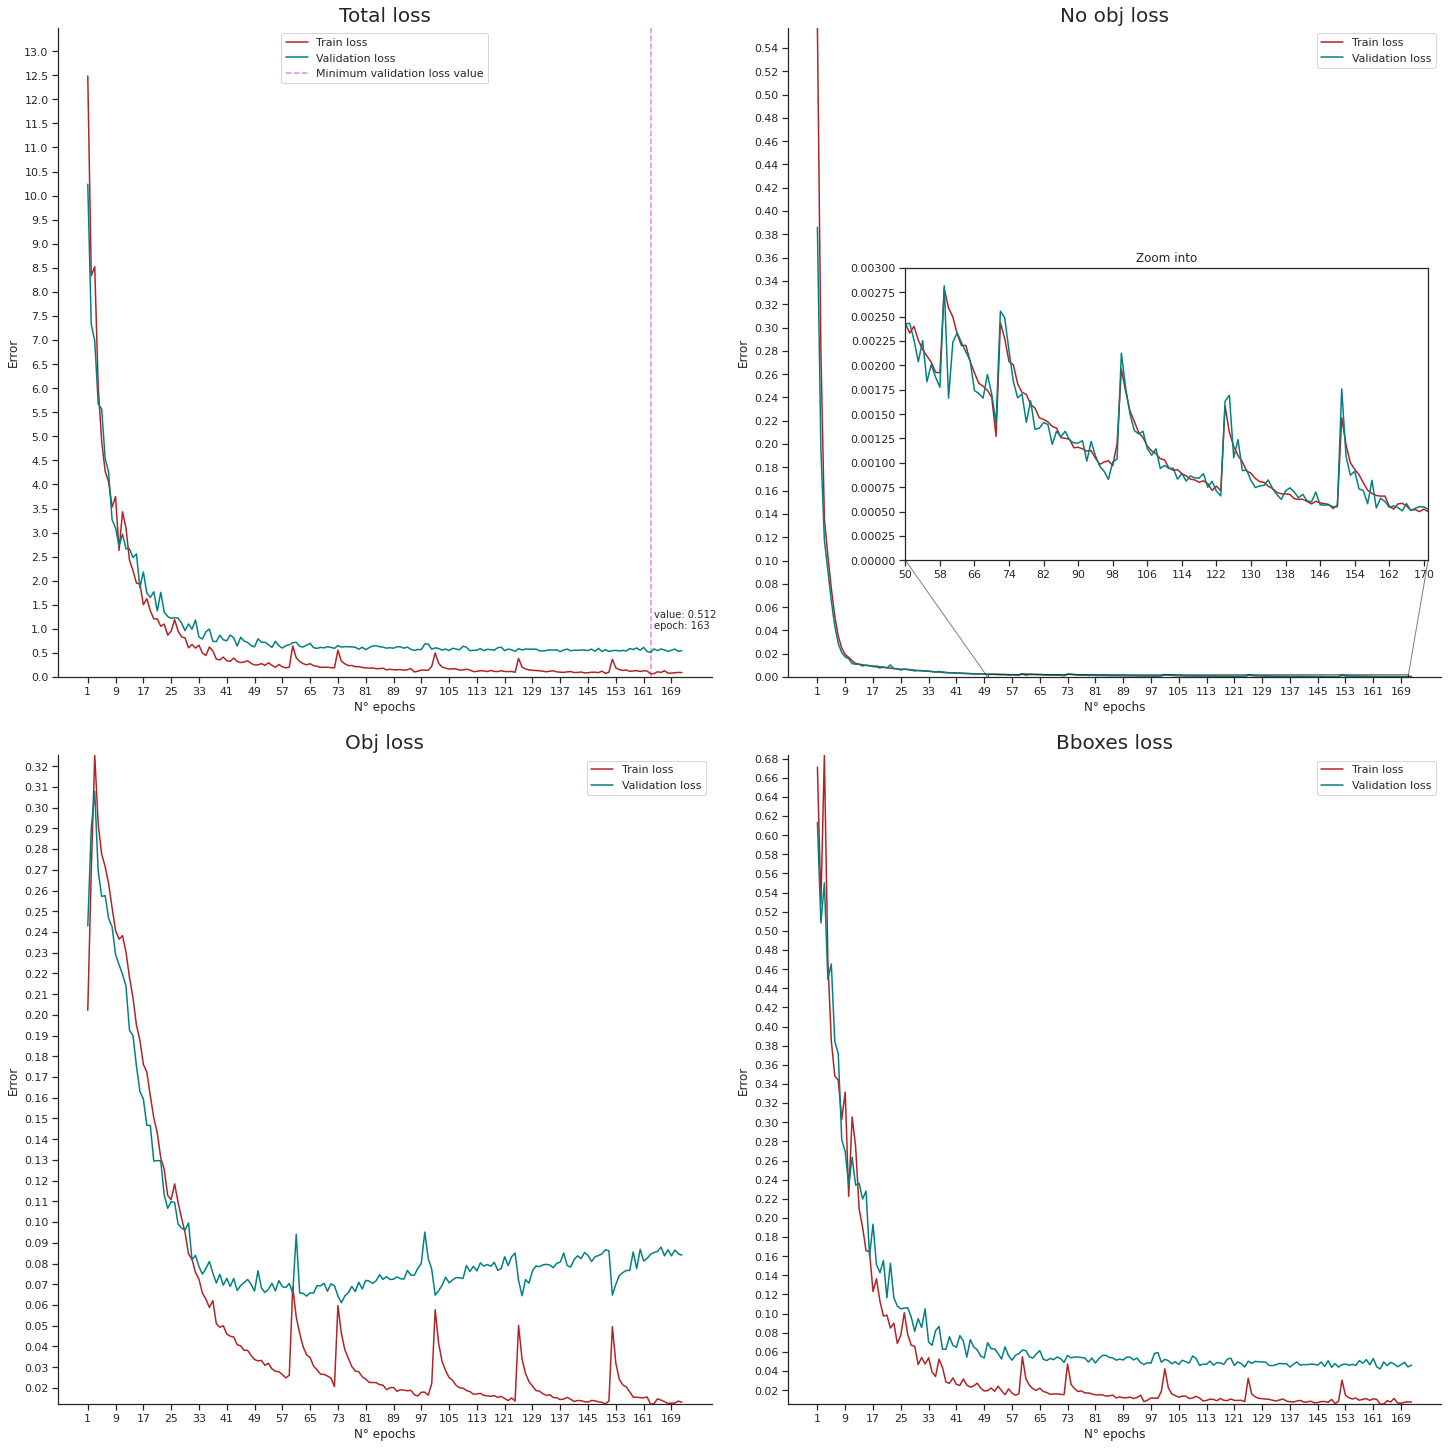

In [ ]:
# read losses from files and plot them
losses_train_total, losses_train_no_obj, losses_train_obj, losses_train_box, losses_val_total, losses_val_no_obj, losses_val_obj, losses_val_box = read_losses()
plot_loss(losses_train_total, losses_train_no_obj, losses_train_obj, losses_train_box, losses_val_total, losses_val_no_obj, losses_val_obj, losses_val_box)

In [ ]:
# create dataset that contains all instance with coordinate [top left x y, w, h]
db_tmp = dataset_bbox_for_obj_detection(LABEL_FILE)
# apply condition on db_tmp to return only row where the Box_Label value is [], so the images where there isn't any ship
db_NO_SHIPS = db_tmp[db_tmp['Box_Label'].isin([[]])]
# apply condition on db_tmp to return only row where the ImageId is in df_val_SHIPS, in this way I have the same df_val_SHIPS with real coordinate [top left x y, w, h]
db_tuning_SHIPS = db_tmp[db_tmp['ImageId'].isin(df_val_SHIPS['ImageId'].tolist())]
# create dataset for tuning and shuffle it
db_tuning = pd.concat([db_tuning_SHIPS, db_NO_SHIPS.iloc[range(len(db_tuning_SHIPS))]], ignore_index=True).sample(frac=1)
# define tuning dataset
YoloD_tuning = YOLODatasetForEvaluation(db_tuning, IMG_DIR, ANCHORS, S, transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))
# create iterator
dataloader_tuning = torch.utils.data.DataLoader(YoloD_tuning, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, 
                                                drop_last=False, collate_fn=collate_for_evaluation)

In [ ]:
# does tuning
tuning_hyperparameters(model, dataloader_tuning)

------------------------------MAP------------------------------
			  overlapThresh
╒═══════════════╤═══════╤═══════╤═══════╤═══════╕
│ objThresold   │ 0.6   │ 0.7   │ 0.8   │ 0.9   │
╞═══════════════╪═══════╪═══════╪═══════╪═══════╡
│ 0.6           │ 0.814 │ 0.816 │ 0.814 │ 0.79  │
├───────────────┼───────┼───────┼───────┼───────┤
│ 0.7           │ 0.817 │ 0.82  │ 0.819 │ 0.795 │
├───────────────┼───────┼───────┼───────┼───────┤
│ 0.8           │ 0.822 │ 0.822 │ 0.821 │ 0.799 │
├───────────────┼───────┼───────┼───────┼───────┤
│ 0.9           │ 0.777 │ 0.779 │ 0.78  │ 0.764 │
├───────────────┼───────┼───────┼───────┼───────┤
│ 1             │ 0.247 │ 0.245 │ 0.245 │ 0.247 │
╘═══════════════╧═══════╧═══════╧═══════╧═══════╛
------------------------------MAP_50------------------------------
			  overlapThresh
╒═══════════════╤═══════╤═══════╤═══════╤═══════╕
│ objThresold   │ 0.6   │ 0.7   │ 0.8   │ 0.9   │
╞═══════════════╪═══════╪═══════╪═══════╪═══════╡
│ 0.6           │ 0.896 │ 0.889

## 12 Test Model

### 12.1 Functions

In [ ]:
""" FUNCTION FOR TEST EVALUATION """

# evaluation of MAP for test set
def final_evaluation(model, dataloader_test, objThresold, overlapThresh):
# make model in evaluation mode
  model.eval()
  # holds all results
  MAP_tmp = []
  # extract result    
  for x, y in tqdm(dataloader_test, leave=True):
    with torch.no_grad():
          # convert to rigth device
          x = x.to(DEVICE)
          # inside this all will cast in float 16
          with torch.cuda.amp.autocast():
            # output of model
            out = model(x)
            # compute mean average precision
            MAP_tmp.append(map_score_for_bboxes(out, y, SCALED_ANCHORS, objThresold=objThresold, overlapThresh=overlapThresh))

  return {'map':np.mean([val["map"] for val in MAP_tmp]), 'map_50':np.mean([val["map_50"] for val in MAP_tmp]),
          'map_75':np.mean([val["map_75"] for val in MAP_tmp])}

### 12.2 Main code

In [ ]:
# create dataset that contains all instance with coordinate [top left x y, w, h]
db_tmp = dataset_bbox_for_obj_detection(LABEL_FILE)
# apply condition on db_tmp to return only row where the Box_Label value is [], so the images where there isn't any ship
db_NO_SHIPS = db_tmp[db_tmp['Box_Label'].isin([[]])]
# apply condition on db_tmp to return only row where the ImageId is in df_test_SHIPS, in this way I have the same df_test_SHIPS with real coordinate [top left x y, w, h]
db_test_SHIPS = db_tmp[db_tmp['ImageId'].isin(df_test_SHIPS['ImageId'].tolist())]
# create dataset for tuning and shuffle it (NB I start from len(db_tuning_SHIPS), in this way I don't take images just used for tuning phase)
db_test = pd.concat([db_test_SHIPS, db_NO_SHIPS.iloc[range(len(db_tuning_SHIPS), len(db_tuning_SHIPS) + len(db_test_SHIPS))]], ignore_index=True).sample(frac=1)
# define test dataset
YoloD_test = YOLODatasetForEvaluation(db_test, IMG_DIR, ANCHORS, S, transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))
# create iterator
dataloader_test = torch.utils.data.DataLoader(YoloD_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, 
                                                drop_last=False, collate_fn=collate_for_evaluation)

In [ ]:
dict_result = final_evaluation(model, dataloader_test, objThresold=0.8, overlapThresh=0.6)
# print summary 
data = [[dict_result[key] for key in dict_result.keys()]]
col_names = [key.upper() for key in dict_result.keys()]
print("\n",tabulate(data, headers=col_names, tablefmt="fancy_grid", numalign="left"))

  0%|          | 0/1064 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:146: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor


 ╒══════════╤══════════╤══════════╕
│ MAP      │ MAP_50   │ MAP_75   │
╞══════════╪══════════╪══════════╡
│ 0.824528 │ 0.904046 │ 0.857076 │
╘══════════╧══════════╧══════════╛


## 13 Demo

### 13.1 Functions

In [16]:
# extract bboxes predicted for an image in real coordinate (top left x y, w, h)
def extract_predicitons_for_image(preds, rescaled_anchors, S=[24, 48, 96], img_size=768., objThresold=0.8, overlapThresh=0.6):
  # return best bboxes with real coordinate, 
  # (is a list of list of list)(external list is for each image, mid list all bboxes for this image, in the last list I have single bbox)
  bboxes_pred_0 = extract_bboxes_for_S(preds[0], rescaled_anchors[0], S[0], img_size, objThresold)
  bboxes_pred_1 = extract_bboxes_for_S(preds[1], rescaled_anchors[1], S[1], img_size, objThresold)
  bboxes_pred_2 = extract_bboxes_for_S(preds[2], rescaled_anchors[2], S[2], img_size, objThresold)
  # put in a same list all bbox for all differents scales
  bboxes_pred = [img_0 + img_1 + img_2 for img_0, img_1, img_2 in zip(bboxes_pred_0, bboxes_pred_1, bboxes_pred_2)]
  # remove overlapping boxes
  # NB I do in this way because in each scale of target I have a bbox for each boat, so for accuracy I hold even overlapping among different scales
  # after this function I have a list of list with only the best bboxes for each image
  bboxes_pred = non_maximum_suppression_for_accuracy(bboxes_pred, overlapThresh)
  return bboxes_pred



# create demo and save it in drive  NB rand_n * 2 must be divisible by 4
def create_demo_file_and_save_it_in_drive(img_dir_demo, dir_demo, zip_name="Demo", rand_n=10):
  # crete folder for demo
  os.mkdir(dir_demo)
  # create folder for demo image
  os.mkdir(img_dir_demo)
  # create demo annotations file with 10 random instance from each dataset
  db_demo = pd.concat([db_test_SHIPS.sample(n=rand_n), db_NO_SHIPS.sample(n=rand_n)], ignore_index=True).sample(frac=1)

  # normalize data to read in easy way when I will call pd.read_csv
  for i in range(db_demo.shape[0]):
    # if list is empty as code I use ''
    if not db_demo.iloc[i, 1]:
      db_demo.iloc[i, 1] = ''
    else:
      # if there is a list of list I use as code ? between lists and : between elements belong to same list
      if isinstance(db_demo.iloc[i, 1][0], list):
        tmp = ""
        for l in db_demo.iloc[i, 1]:
         tmp = tmp + ':'.join(str(elem) for elem in l) + "?"
        db_demo.iloc[i, 1] = tmp[:-1]
      else:
        db_demo.iloc[i, 1] = ':'.join(str(elem) for elem in db_demo.iloc[i, 1])

  # save annotations file as csv
  db_demo.to_csv(os.path.join(dir_demo, 'annotations.csv'), index=False)
  # copy each image in demo annotations to image dir demo
  for image_id in db_demo["ImageId"]:
    shutil.copyfile(os.path.join(IMG_DIR, image_id), os.path.join(img_dir_demo, image_id))
  # create zip file for demo
  shutil.make_archive(zip_name, 'zip', dir_demo)
  # move to drive
  shutil.move('/content/Demo.zip', '/content/drive/MyDrive/'+ zip_name +'.zip')



# copy demo from drive to this os, unzip them and eliminate zip
def extract_demo_file(zip_demo_name, folder_name):
  # create folder where extract zip
  os.mkdir(folder_name)
  # copy zip in right folder
  shutil.copyfile(os.path.join("/content/drive/MyDrive", zip_demo_name), os.path.join("/content", zip_demo_name))
  # unzip
  shutil.unpack_archive(zip_demo_name, os.path.join("/content", folder_name), 'zip')
  # remove zip
  os.remove(zip_demo_name)



# read demo from file and change notation to create list
def read_demo_file(dir_demo):
  # read demo
  df_demo = pd.read_csv(os.path.join(dir_demo, "annotations.csv"))
  # convert lists from code to normal lists
  for i in range(df_demo.shape[0]):
    # case no bboxes
    if isinstance(df_demo.iloc[i, 1], float):
      df_demo.iloc[i, 1]= []
    else:
      # case more than 1 bboxes
      if df_demo.iloc[i, 1].find("?") != -1:
        tmp = df_demo.iloc[i, 1].split('?')
        df_demo.iloc[i, 1] = [np.array(l.split(':'), dtype=int) for l in tmp]
      else:
        df_demo.iloc[i, 1] = [np.array(df_demo.iloc[i, 1].split(':'), dtype=int)]
  return df_demo

### 13.2 Main code


In [24]:
# dir contains images for demo
img_dir_demo = "/content/Demo/Images"
# dir contains all demo stuff
dir_demo = "/content/Demo"
# create demo in random way and save zip with all stuff in
#create_demo_file_and_save_it_in_drive(img_dir_demo, dir_demo)
# extract demo from zip
extract_demo_file('Demo.zip', 'Demo')
# return pandas dataframe
df_demo = read_demo_file(dir_demo)
# create dataset
YoloD_demo = YOLODatasetForEvaluation(df_demo, img_dir_demo, transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))
# create iterator
dataloader_demo = torch.utils.data.DataLoader(YoloD_demo, batch_size=1, shuffle=False, num_workers=1, 
                                                drop_last=False, collate_fn=collate_for_evaluation)

In [26]:
# create axes 
fig, axs = plt.subplots(df_demo.shape[0] // 4, 4, figsize=(40, 40), constrained_layout=True)
# make model in evaluation mode
model.eval()
# print all images
for i, (x, y) in enumerate(dataloader_demo):
  with torch.no_grad():
    # convert to rigth device
    x = x.to(DEVICE)
    # inside this all will cast in float 16
    with torch.cuda.amp.autocast():
      out = model(x)
    # extract bboxes from output
    pred_bboxes_for_image = extract_predicitons_for_image(out, SCALED_ANCHORS)
    # take image to plot
    img = np.array(PIL.Image.open(os.path.join(img_dir_demo, df_demo.iloc[i, 0])))
    # remove axis
    axs[i // 4, i % 4].axis('off')
    # plot image
    axs[i // 4, i % 4].imshow(img)
    # because I have batch size equal 1
    y_gt = y[0]
    # use it to plot only one legend for each image and ship of target
    rect_gt = None
    # ground truth
    for k, bbox in enumerate(y_gt):
      x, y, x_w, y_w = bbox
      # Create a Rectangle patch                                                                        
      rect_gt = patches.Rectangle((x, y), x_w, y_w, linewidth=3, edgecolor='gold', facecolor='none')
      # Add the patch to the Axes
      axs[i // 4, i % 4].add_patch(rect_gt) 
    # because I have batchsize equal 1
    pred_bboxes_for_image = pred_bboxes_for_image[0]
    # use it to plot only one legend for each image and ship of prediction
    rect_p = None
    # predicted bboxes
    for bboxes in pred_bboxes_for_image:
      _, x, y, x_w, y_w = bboxes
      # Create a Rectangle patch
      rect_p = patches.Rectangle((x, y), x_w, y_w, linewidth=2, edgecolor='magenta', linestyle="-.", facecolor='none')
      # Add the patch to the Axes
      axs[i // 4, i % 4].add_patch(rect_p)

    # to plot legend without double instance 
    if rect_gt and rect_p:
      axs[i // 4, i % 4].legend([rect_gt, rect_p], ["ground truth", "predicted bbox"])
    elif rect_gt:
      axs[i // 4, i % 4].legend([rect_gt], ["ground truth"])
    elif rect_p:
      axs[i // 4, i % 4].legend([rect_p], ["predicted bbox"])

    axs[i // 4, i % 4].set_title(f"N° ground truth : {len(y_gt)} | N° predicted boxes : {len(pred_bboxes_for_image)}")

Output hidden; open in https://colab.research.google.com to view.